# RNN学习笔记

RNN是两种神经网络模型的缩写，一种是递归神经网络（Recursive Neural Network），一种是循环神经网络（Recurrent Neural Network）。虽然这两种神经网络有着千丝万缕的联系，但是本文主要讨论的是第二种神经网络模型——循环神经网络（Recurrent Neural Network）。

循环神经网络是指一个随着时间的推移，重复发生的结构。在自然语言处理（NLP），语音图像等多个领域均有非常广泛的应用。RNN网络和其他网络最大的不同就在于RNN能够实现某种“记忆功能”，是进行时间序列分析时最好的选择。如同人类能够凭借自己过往的记忆更好地认识这个世界一样。RNN也实现了类似于人脑的这一机制，对所处理过的信息留存有一定的记忆，而不像其他类型的神经网络并不能对处理过的信息留存记忆。

## RNN原理

循环神经网络的原理并不十分复杂，本节主要从原理上分析RNN的结构和功能，不涉及RNN的数学推导和证明，整个网络只有简单的输入输出和网络状态参数。一个典型的RNN神经网络如图所示：

> <img src="http://static.open-open.com/lib/uploadImg/20150829/20150829181722_204.png" width="200"/>

由上图可以看出：一个典型的RNN网络包含一个输入x，一个输出h和一个神经网络单元A。和普通的神经网络不同的是，RNN网络的神经网络单元A不仅仅与输入和输出存在联系，其与自身也存在一个回路。这种网络结构就揭示了RNN的实质：上一个时刻的网络状态信息将会作用于下一个时刻的网络状态。如果上图的网络结构仍不够清晰，RNN网络还能够以时间序列展开成如下形式：

> ![rnn-2.png](http://static.open-open.com/lib/uploadImg/20150829/20150829181722_413.png)

等号右边是RNN的展开形式。由于RNN一般用来处理序列信息，因此下文说明时都以时间序列来举例，解释。等号右边的等价RNN网络中最初始的输入是x0，输出是h0，这代表着0时刻RNN网络的输入为x0，输出为h0，网络神经元在0时刻的状态保存在A中。当下一个时刻1到来时，此时网络神经元的状态不仅仅由1时刻的输入x1决定，也由0时刻的神经元状态决定。以后的情况都以此类推，直到时间序列的末尾t时刻。

上面的过程可以用一个简单的例子来论证：假设现在有一句话“I want to play basketball”，由于自然语言本身就是一个时间序列，较早的语言会与较后的语言存在某种联系，例如刚才的句子中“play”这个动词意味着后面一定会有一个名词，而这个名词具体是什么可能需要更遥远的语境来决定，因此一句话也可以作为RNN的输入。回到刚才的那句话，这句话中的5个单词是以时序出现的，我们现在将这五个单词编码后依次输入到RNN中。首先是单词“I”，它作为时序上第一个出现的单词被用作x0输入，拥有一个h0输出，并且改变了初始神经元A的状态。单词“want”作为时序上第二个出现的单词作为x1输入，这时RNN的输出和神经元状态将不仅仅由x1决定，也将由上一时刻的神经元状态或者说上一时刻的输入x0决定。之后的情况以此类推，直到上述句子输入到最后一个单词“basketball”。

接下来我们需要关注RNN的神经元结构：

> <img src="http://static.open-open.com/lib/uploadImg/20150829/20150829181722_450.png" style="height:184px"/>

上图依然是一个RNN神经网络的时序展开模型，中间t时刻的网络模型揭示了RNN的结构。可以看到，原始的RNN网络的内部结构非常简单。神经元A在t时刻的状态仅仅是t-1时刻神经元状态与t时刻网络输入的双曲正切函数的值，这个值不仅仅作为该时刻网络的输出，也作为该时刻网络的状态被传入到下一个时刻的网络状态中，这个过程叫做RNN的正向传播（forward propagation）。注：双曲正切函数的解析式如下：

$$f(x)=tanh(x)=\frac{sinh(x)}{cosh(x)}=\frac {e^{x}-e^{-x}}{e^{x}+e^{-x}}$$

双曲正切函数的求导如下：

$$f'(x)=(tanh(x))^{'}=\frac{1}{cosh^{2}(x)}=\frac {4}{(e^{x}+e^{-x})^{2}}=1-tanh^{2}(x)$$

双曲正切函数的图像如下所示：

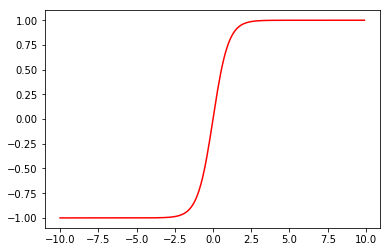

In [10]:
from matplotlib import pyplot as plt
import numpy as np

x = np.arange(-10, 10, 0.1)
y = np.tanh(x)
fig = plt.figure("tanh-fig")
ax = fig.add_subplot(111)
ax.plot(x, y, "r")
plt.show()

这里就带来一个问题：为什么RNN网络的激活函数要选用双曲正切而不是sigmod呢？（RNN的激活函数除了双曲正切，RELU函数也用的非常多）原因在于RNN网络在求解时涉及时间序列上的大量求导运算，使用sigmod函数容易出现梯度消失，且sigmod的导数形式较为复杂。事实上，即使使用双曲正切函数，传统的RNN网络依然存在梯度消失问题，无法“记忆”长时间序列上的信息，这个bug直到LSTM上引入了单元状态后才算较好地解决。

## 数学基础

这一节主要介绍与RNN相关的数学推导，由于RNN是一个时序模型，因此其求解过程可能和一般的神经网络不太相同。首先需要介绍一下RNN完整的结构图，上一节给出的RNN结构图省去了很多内部参数，仅仅作为一个概念模型给出。

> ![RNN_STRUCTURE](https://pic1.zhimg.com/80/v2-3bc30e9a2d740fff417e47dcf7d636bc_hd.jpg)

上图表明了RNN网络的完整拓扑结构，从图中我们可以看到RNN网络中的参数情况。在这里我们只分析t时刻网络的行为与数学推导。t时刻网络迎来一个输入xt，网络此时刻的神经元状态st用如下式子表达：

$$s_{t}=\phi (Ux_{t}+Ws_{t-1})$$

t时刻的网络状态st不仅仅要输入到下一个时刻t+1的网络状态中去，还要作为该时刻的网络输出。当然，st不能直接输出，在输出之前还要再乘上一个系数V，而且为了误差逆传播时的方便通常还要对输出进行归一化处理，也就是对输出进行softmax化。因此，t时刻网络的输出ot表达为如下形式：

$$o_{t}=\varphi (Vs_{t})$$

为了表达方便，笔者将上述两个公式做如下变换：

$$\left\{
\begin{aligned}
&s_{t}^{*}=Ux_{t}+Ws_{t-1}\rightarrow s_{t}=\phi (s_{t}^{*})\\
&o_{t}^{*}=Vs_{t}\rightarrow o_{t}=\varphi (o_{t}^{*})
\end{aligned}
\right.$$

以上，就是RNN网络的数学表达了，接下来我们需要求解这个模型。在论述具体解法之前首先需要明确两个问题：

* 优化目标函数是什么？

* 待优化的量是什么？

只有在明确了这两个问题之后才能对模型进行具体的推导和求解。关于第一个问题，笔者选取模型的损失函数作为优化目标；关于第二个问题，我们从RNN的结构图中不难发现：只要我们得到了模型的U，V，W这三个参数就能完全确定模型的状态。因此该优化问题的优化变量就是RNN的这三个参数。顺便说一句，RNN模型的U，V，W三个参数是全局共享的，也就是说不同时刻的模型参数是完全一致的，这个特性使RNN得参数变得稍微少了一些。

### 损失函数

不做过多的讨论，RNN的损失函数选用交叉熵（Cross Entropy），这是机器学习中使用最广泛的损失函数之一了，其通常的表达式如下所示：

$$Loss=-\sum_{i=0}^{n}y_{i}lny_{i}^{*}$$

上面式子是交叉熵的标量形式，y_i是真实的标签值，y_i\*是模型给出的预测值，最外面之所以有一个累加符号是因为模型输出的一般都是一个多维的向量，只有把n维损失都加和才能得到真实的损失值。交叉熵在应用于RNN时需要做一些改变：

* 首先，RNN的输出是向量形式，没有必要将所有维度都加在一起，直接把损失值用向量表达就可以了；

* 其次，由于RNN模型处理的是序列问题，因此其模型损失不能只是一个时刻的损失，应该包含全部N个时刻的损失。

故RNN模型在t时刻的损失函数写成如下形式：

$$Loss_{t}=-[y_{t}ln(o_{t})+(y_{t}-1)ln(1-o_{t})]$$

全部N个时刻的损失函数（全局损失）表达为如下形式：

$$Loss=\sum_{t=1}^{N}Loss_{t}=-\sum_{t=1}^{N}[y_{t}ln(o_{t})+(y_{t}-1)ln(1-o_{t})]$$

需要说明的是：yt是t时刻输入的真实标签值，ot为模型的预测值，N代表全部N个时刻。下文中为了书写方便，将Loss简记为L。在结束本小节之前，最后补充一个softmax函数的求导公式：

$$\varphi '(x)=\varphi (x)(1-\varphi (x))$$

### BPTT算法

由于RNN模型与时间序列有关，因此不能直接使用BP（back propagation）算法。针对RNN问题的特殊情况，提出了BPTT算法。BPTT的全称是“随时间变化的反向传播算法”（back propagation through time）。这个方法的基础仍然是常规的链式求导法则，接下来开始具体推导。虽然RNN的全局损失是与全部N个时刻有关的，但为了简单笔者在推导时只关注t时刻的损失函数。

首先求出t时刻下损失函数关于o_t\*的微分：

$$\frac{\partial L_{t}}{\partial o_{t}^{*}}=\frac{\partial L_{t}}{\partial o_{t}}\times \frac{\partial o_{t}}{\partial o_{t}^{*}}=\frac{\partial L_{t}}{\partial o_{t}}\times \frac{\varphi (o_{t}^{*})}{\partial o_{t}^{*}}=\frac{\partial L_{t}}{\partial o_{t}}\times \varphi' (o_{t}^{*})
$$

求出损失函数关于参数V的微分：

$$\frac{\partial L_{t}}{\partial V}=\frac{\partial L_{t}}{\partial Vs_{t}}\times \frac{\partial Vs_{t}}{\partial V}=
\frac{\partial L_{t}}{\partial o_{t}^{*}}\times s_{t}=\frac{\partial L_{t}}{\partial o_{t}}\times \varphi' (o_{t}^{*})\times s_{t}$$

因此，全局损失关于参数V的微分为：

$$\frac{\partial L}{\partial V}=\sum_{t=1}^{N}\frac{\partial L_{t}}{\partial V}=\sum_{t=1}^{N}\frac{\partial L_{t}}{\partial o_{t}}\times \varphi' (o_{t}^{*})\times s_{t}$$

求出t时刻的损失函数关于关于st\*的微分：

$$\frac{\partial L_{t}}{\partial s_{t}^{*}}=\frac{\partial s_{t}}{\partial s_{t}^{*}}\times \frac{\partial s_{t}^{T}V^{T}}{\partial s_{t}}\times \frac{\partial L_{t}}{\partial Vs_{t}}=\phi'(s_{t}^{*})\times V^{T} \times \frac{\partial L_{t}}{\partial o_{t}^{*}}=\phi'(s_{t}^{*})\times V^{T} \times \frac{\partial L_{t}}{\partial o_{t}}\times \varphi' (o_{t}^{*})$$

求出t时刻的损失函数关于s_t-1\*的微分：

$$\frac{\partial L_{t}}{\partial s_{t-1}^{*}}=\frac{\partial s_{t}^{*}}{\partial s_{t-1}^{*}}\times \frac{\partial L_{t}}{\partial s_{t}^{*}}=\frac{\partial [\phi (s_{t-1}^{*})W+Ux_{t}]}{\partial s_{t-1}^{*}}\times \frac{\partial L_{t}}{\partial s_{t}^{*}}=W\phi'(s_{t-1}^{*}) \times \frac{\partial L_{t}}{\partial s_{t}^{*}}$$

求出t时刻损失函数关于参数U的偏微分。注意：由于是时间序列模型，因此t时刻关于U的微分与前t-1个时刻都有关，在具体计算时可以限定最远回溯到前n个时刻，但在推导时需要将前t-1个时刻全部带入：

$$\frac{\partial L_{t}}{\partial U}=\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times \frac{\partial s_{k}^{*}}{\partial U}=\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times \frac{\partial (Ux_{k}+Ws_{k-1})}{\partial U}=\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times x_{k}^{T}$$

因此，全局损失关于U的偏微分为：

$$\frac{\partial L}{\partial U}=\sum_{t=1}^{N}\frac{\partial L_{t}}{\partial U}=\sum_{t=1}^{N}\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times \frac{\partial s_{k}^{*}}{\partial U}=\sum_{t=1}^{N}\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times x_{k}^{T}$$

求t时刻损失函数关于参数W的偏微分，和上面相同的道理，在这里仍然要计算全部前t-1时刻的情况：

$$\frac{\partial L_{t}}{\partial W}=\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times \frac{\partial s_{k}^{*}}{\partial W}=\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times \frac{\partial (Ux_{k}+Ws_{k-1})}{\partial W}=\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times s_{k-1}^{T}$$

因此，全局损失关于参数W的微分结果为：

$$\frac{\partial L}{\partial W}=\sum_{t=1}^{N}\frac{\partial L_{t}}{\partial W}=\sum_{t=1}^{N}\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times \frac{\partial s_{k}^{*}}{\partial W}=\sum_{t=1}^{N}\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times s_{k-1}^{T}$$

至此，全局损失函数关于三个主要参数的微分都已经得到了。整理如下：

$$\left\{
\begin{aligned}
&\frac{\partial L}{\partial V}=\sum_{t=1}^{N}\frac{\partial L_{t}}{\partial o_{t}}\times \varphi' (o_{t}^{*})\times s_{t}\\
&\frac{\partial L}{\partial U}=\sum_{t=1}^{N}\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times x_{k}^{T}\\
&\frac{\partial L}{\partial W}=\sum_{t=1}^{N}\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times s_{k-1}^{T}
\end{aligned}
\right.$$

接下来进一步化简上述微分表达式，化简的主要方向为t时刻的损失函数关于ot的微分以及关于st\*的微分。已知t时刻损失函数的表达式，求关于ot的微分：

$$\frac{\partial L_{t}}{\partial o_{t}}=\frac {-\partial [y_{t}ln(o_{t})+(y_{t}-1)ln(1-o_{t})]}{\partial o_{t}}=- (\frac{y_{t}}{o_{t}}+\frac{y_{t}-o_{t}}{1-o_{t}})=-\frac{y_t-o_{t}}{o_{t}(1-o_{t})}$$

softmax函数求导：

$$\phi '(o_{t}^{*})=o_{t}(1-o_{t})$$

因此

$$\frac{\partial L_{t}}{\partial o_{t}}\times \varphi' (o_{t}^{*})=-\frac{y_t-o_{t}}{o_{t}(1-o_{t})} \times o_{t}(1-o_{t})=o_{t}-y_{t}$$

又因为：

$$\frac{\partial L_{t}}{\partial s_{t}^{*}}=\phi'(s_{t}^{*})\times V^{T} \times \frac{\partial L_{t}}{\partial o_{t}}\times \varphi' (o_{t}^{*})=(1-\phi ^{2}(s_{t}^{*}))\times [V^{T} \times (o_{t}-y_{t})]=(1-s_{t}^{2})\times [V^{T} \times (o_{t}-y_{t})]$$

且

$$\frac{\partial L_{t}}{\partial s_{t-1}^{*}}=W\phi'(s_{t-1}^{*}) \times \frac{\partial L_{t}}{\partial s_{t}^{*}}=(1-s_{t-1}^{2})\times W^{T}\times\frac{\partial L_{t}}{\partial s_{t}^{*}}$$

有了上面的数学推导，我们可以得到全局损失关于U，V，W三个参数的梯度公式：

$$\left\{
\begin{aligned}
&\frac{\partial L}{\partial V}=\sum_{t=1}^{N}(o_{t}-y_{t})\times s_{t}\\
&\frac{\partial L}{\partial U}=\sum_{t=1}^{N}\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times x_{k}^{T}\\
&\frac{\partial L}{\partial W}=\sum_{t=1}^{N}\sum_{k=1}^{t}\frac{\partial L_{t}}{\partial s_{k}^{*}}\times s_{k-1}^{T}
\end{aligned}
\right.$$

由于参数U和W的微分公式不仅仅与t时刻有关，还与前面的t-1个时刻都有关，因此无法写出直接的计算公式。不过上面已经给出了t时刻的损失函数关于s_t-1的微分递推公式，想来求解这个式子也是十分简单的，在这里就不赘述了。

以上就是关于BPTT算法的全部数学推导。从最终结果可以看出三个公式的偏微分结果非常简单，在具体的优化过程中可以直接带入进行计算。对于这种优化问题来说，最常用的方法就是梯度下降法。针对本文涉及的RNN问题，可以构造出三个参数的梯度更新公式：

$$\left\{
\begin{aligned}
&V:=V-\eta \times \frac{\partial L}{\partial V}\\
&U:=U-\eta \times \frac{\partial L}{\partial U}\\
&W:=W -\eta \times \frac{\partial L}{\partial W}
\end{aligned}
\right.$$

依靠上述梯度更新公式就能够迭代求解三个参数，直到三个参数的值发生收敛。

## 后记

这是笔者第一次尝试推导RNN的数学模型，在推导过程中遇到了非常多的bug。非常感谢互联网上的一些公开资料和博客，给了我非常大的帮助和指引。接下来笔者将尝试实现一个单隐层的RNN模型用于实现一个语义预测模型。